In [1]:
!pip install transformers torch accelerate bitsandbytes
!pip install -U transformers
!pip install -U bitsandbytes
!pip install mypy
!pip install ruff
!pip install bandit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 103.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.0/127.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from google.colab import userdata

In [3]:
# Get the Hugging Face token from user data
my_key = userdata.get('TOKEN')

# Model identifier
model_id = "meta-llama/Llama-3.2-3B-Instruct"  # Updated model ID

# BitsAndBytes configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load the tokenizer with authentication
tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=my_key) # Pass the token here as well

# Set padding token
tokenizer.pad_token = tokenizer.eos_token

# Load the model with authentication
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
    use_auth_token=my_key
)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:810: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [4]:
import numpy as np
import random
import subprocess
import tempfile
import os
import re
import pandas as pd
import subprocess
import tempfile
import matplotlib.pyplot as plt
import ast
import time

In [5]:
class BaseAgent:
    def __init__(self, pipeline, name="BaseAgent"):
        self.pipeline = pipeline
        self.name = name
        self.epsilon = 0.1  # Probabilidade de explorar
        self.q_values = {}  # Dicionário para armazenar os Q-values para cada ação

    def generate_response(self, prompt):
        """Gera uma resposta com base no prompt fornecido."""
        response = self.pipeline(prompt)
        return response[0]['generated_text']

    def choose_action(self, state):
        """
        Escolhe uma ação usando epsilon-greedy, baseado nos Q-values.
        """
        if state.get('stage') == 'P':
            return 'prompt_inicial'

        if not self.q_values:
            # Inicializa Q-values para todas as ações
            self.q_values = {action: 0 for action in self.get_actions()}

        if np.random.rand() < self.epsilon:
            # Escolha aleatória (exploração)
            return random.choice(list(self.q_values.keys()))
        else:
            # Escolha a melhor ação (exploração)
            return max(self.q_values, key=self.q_values.get)

    def update_q_value(self, action, reward, alpha=0.5):
        """
        Atualiza o Q-value da ação escolhida com base na recompensa recebida.
        """
        self.q_values[action] = self.q_values[action] + alpha * (reward - self.q_values[action])

    def get_actions(self):
        """
        Retorna uma lista das ações disponíveis para o agente.
        (Implementado nas subclasses)
        """
        raise NotImplementedError


In [6]:
class CodificadorAgent(BaseAgent):
    def __init__(self, pipeline):
        super().__init__(pipeline, name="Codificador")

    def prompt_inicial(self, state):
        prompt = f"""
        Você é um programador do ramo da ciência de dados. Por favor, escreva apenas um único código Python necessário para realizar essa tarefa.

        Seu trabalho é escrever um script para limpar os dados de vendas fornecidos.
        O script deve corrigir os erros de formatação e garantir que os dados estejam prontos para análise.

        Problema: {state['problem']}
        Dados disponíveis: {state.get('dataset', 'Resumo dos dados não fornecido')}
        """

        return [self.generate_response(prompt), prompt]

    def processar_dados(self, state):
        prompt = f"""
        Limpe e prepare os dados com base no problema a seguir:

        Problema: {state['problem']}
        Dados disponíveis: {state.get('dataset', 'Resumo dos dados não fornecido')}
        Feedback: {state.get('feedback', 'Sem feedback disponível')}

        Por favor, escreva apenas um único código Python necessário para realizar essa tarefa.
        """
        return [self.generate_response(prompt), prompt]

    def analisar_dados(self, state):
        prompt = f"""
        Analise os dados com base no problema a seguir:

        Problema: {state['problem']}
        Código anterior: {state.get('code', 'Nenhum código fornecido')}
        Feedback: {state.get('feedback', 'Sem feedback disponível')}

        Por favor, escreva apenas um único código Python para realizar as análises estatísticas ou construir modelos de aprendizado de máquina.
        """
        return [self.generate_response(prompt), prompt]

    def visualizar_resultados(self, state):
        prompt = f"""
        Gere visualizações dos dados com base no problema a seguir:

        Problema: {state['problem']}
        Dados disponíveis: {state.get('data_summary', 'Resumo dos dados não fornecido')}
        Feedback: {state.get('feedback', 'Sem feedback disponível')}

        Por favor, escreva apenas um único código Python para criar gráficos ou visualizações relevantes.
        """
        return [self.generate_response(prompt), prompt]


    def get_actions(self):
        """
        Retorna as ações disponíveis para o Codificador.
        """
        return ['processar_dados', 'analisar_dados', 'visualizar_resultados']


In [7]:
class RevisorAgent(BaseAgent):
    def __init__(self, pipeline):
        super().__init__(pipeline, name="Revisor")

    def analise_estatica(self, state):
        """
        Analisa o código usando Mypy, Ruff e Bandit.
        """
        def run_tool(command):
            try:
                result = subprocess.run(command, capture_output=True, text=True)
                return result.stdout if result.returncode == 0 else result.stderr
            except Exception as e:
                return str(e)

        with tempfile.NamedTemporaryFile(suffix=".py", delete=False) as temp_file:
            temp_file.write(state['code'].encode("utf-8"))
            temp_filename = temp_file.name

        mypy_output = run_tool(["mypy", temp_filename])
        ruff_output = run_tool(["ruff", temp_filename])
        bandit_output = run_tool(["bandit", "-r", temp_filename])

        os.remove(temp_filename)

        return f"mypy {mypy_output}, ruff: {ruff_output}, bandit: {bandit_output}"

    def executar_codigo(self, state):
        """
        Executa o código gerado e avalia sua funcionalidade.
        """
        try:
            with tempfile.NamedTemporaryFile(suffix=".py", delete=False) as temp_file:
                temp_file.write(state['code'].encode("utf-8"))
                temp_filename = temp_file.name

            result = subprocess.run(
                ["python", temp_filename], capture_output=True, text=True
            )
            if result.returncode == 0:
                return "Executavél"
            else:
                return "Não executavél"
        except Exception as e:
            return "Executavél"

    def propor_refatoracao(self, state):
        prompt = f"""
        Você é um revisor de código. Em um parágrafo curto com 1 a 3 linhas, proponha refatorações para melhorar o código:

        Código:
        {state['code']}
        """
        return self.generate_response(prompt)

    def aprovar_codigo(self, state):
        prompt = f"""
        Você é um aprovador código. Em um parágrafo curto com 1 a 3 linhas, aprove o código como correto e de qualidade:

        Código:
        {state['code']}
        """
        return self.generate_response(prompt)

    def get_actions(self):
        """
        Retorna as ações disponíveis para o Revisor.
        """
        return ['analise_estatica', 'executar_codigo', 'propor_refatoracao', 'aprovar_codigo']


In [8]:
class TrainingEnvironment:
    def __init__(self, problems):
        """
        Inicializa o ambiente com uma lista de problemas.
        """
        self.problems = problems
        self.current_problem = None
        self.state = None
        self.joint_rewards = []  # Armazena as recompensas conjuntas

    def reset(self):
        """
        Reinicia o ambiente selecionando um novo problema e reiniciando o estado.
        """
        self.current_problem = random.choice(self.problems)
        self.state = {
            "problem": self.current_problem["description"],
            "dataset": self.current_problem["dataset"],
            "stage": "P",
            "code": "",
            "feedback": "",
            "score": {"execution": 0, "style": 0, "security": 0, "overall": 0},
            "coder_action": "",
            "reviewer_action": ""

        }
        return self.state


    def extract_code(self, output):
        """
        Extrai o código Python delimitado por ```python ... ``` do texto gerado pelo LLM.

        Parâmetros:
            output (list): Uma lista onde:
                - output[0] é o texto gerado pelo LLM.
                - output[1] é o prompt que gerou o texto.

        O método remove o prompt (output[1]) do início do texto gerado (output[0])
        antes de buscar o código Python.
        """
        # output[0] contém o output do LLM
        # output[1] contém o prompt que gerou o output
        llm_output = output[0]
        prompt = output[1]

        # Remove o prompt do início do output
        if llm_output.startswith(prompt):
            llm_output = llm_output[len(prompt):].lstrip()

        # Procura o código Python delimitado por ```python ... ```
        match = re.search(r"```python(.*?)```", llm_output, re.DOTALL)
        if match:
            return match.group(1).strip()
        else:
            return llm_output.strip()


    def execute_code(self, code):
        """
        Avalia o código fornecido, combinando validação de sintaxe e execução.
        Retorna um dicionário com as métricas coletadas.
        """
        def verificar_sintaxe(codigo):
            """
            Verifica se a sintaxe do código é válida.
            Retorna True se válido, caso contrário levanta um SyntaxError.
            """
            try:
                ast.parse(codigo)
                return True
            except SyntaxError as e:
                return f"Erro de sintaxe: {e}"

        def executar_codigo(codigo):
            """
            Executa o código fornecido e mede o tempo de execução.
            Retorna um dicionário com 'tempo_execucao' e 'erro_execucao'.
            """
            resultados = {'tempo_execucao': None, 'erro_execucao': None}
            start_time = time.time()
            try:
                exec(codigo)
                resultados['tempo_execucao'] = time.time() - start_time
            except Exception as e:
                resultados['erro_execucao'] = f"Erro de execução: {e}"
            return resultados

        resultados = {
            'sintaxe_valida': False,
            'erro_execucao': None,
            'tempo_execucao': None
        }

        # Verificar sintaxe
        sintaxe = verificar_sintaxe(code)
        if sintaxe is not True:
            resultados['erro_execucao'] = sintaxe
            return resultados
        resultados['sintaxe_valida'] = sintaxe

        # Executar o código
        exec_result = executar_codigo(code)
        resultados.update(exec_result)

        return resultados

    def analyze_code(self, code):
        """
        Analisa o código usando Mypy, Ruff e Bandit.
        """
        def run_tool(command):
            try:
                result = subprocess.run(command, capture_output=True, text=True)
                return result.stdout if result.returncode == 0 else result.stderr
            except Exception as e:
                return str(e)

        with tempfile.NamedTemporaryFile(suffix=".py", delete=False) as temp_file:
            temp_file.write(code.encode("utf-8"))
            temp_filename = temp_file.name

        mypy_output = run_tool(["mypy", temp_filename])
        ruff_output = run_tool(["ruff", temp_filename])
        bandit_output = run_tool(["bandit", "-r", temp_filename])

        os.remove(temp_filename)

        return {"mypy": mypy_output, "ruff": ruff_output, "bandit": bandit_output}

    def evaluate_code(self, code):
        """
        Avalia o código gerado e calcula a recompensa conjunta.
        """
        execution_result = self.execute_code(code)
        analysis_result = self.analyze_code(code)

        execution_score = 100 if execution_result["erro_execucao"] is None else 0
        sintaxe_score = 200 if not execution_result["sintaxe_valida"] else -100
        time_score = 1000*execution_result["tempo_execucao"] if execution_result["tempo_execucao"] is not None else 0
        #style_score = 100 if "no issues found" in analysis_result["ruff"].lower() else 50
        #security_score = 100 if "no issues identified" in analysis_result["bandit"].lower() else 50

        #overall_score = (execution_score + style_score + security_score) / 3
        overall_score = (execution_score + sintaxe_score + time_score) / 3
        self.state["code"] = code
        self.state["feedback"] = {
            "execution": execution_result["erro_execucao"] or "Execução bem-sucedida.",
            "style": analysis_result["ruff"],
            "security": analysis_result["bandit"],
        }
        self.state["score"] = {
            "execution": execution_score,
            "sintaxe": sintaxe_score,
            "time": time_score,
            "overall": overall_score,
        }

        joint_reward = overall_score
        return joint_reward

    def step_coder(self, coder_agent):
        """
        Executa o passo do coder no ambiente.
        """
        print("------ Passo do Coder ------")

        coder_action = coder_agent.choose_action(self.state)
        self.state["coder_action"] = coder_action
        print(f"Ação do Coder: {coder_action}")

        output = getattr(coder_agent, coder_action)(self.state)
        #print(f"Output Gerado pelo Coder:\n{output[0]}")
        code = self.extract_code(output)
        print(f"Código Gerado pelo Coder:\n{code}")

        self.state["stage"] = "R"
        self.state["code"] = code

    def step_reviewer(self, reviewer_agent):
        """
        Executa o passo do reviewer no ambiente.
        """
        print("------ Passo do Reviewer ------")

        reviewer_action = reviewer_agent.choose_action(self.state)
        self.state["reviewer_action"] = reviewer_action
        print(f"Ação do Reviewer: {reviewer_action}")

        feedback = getattr(reviewer_agent, reviewer_action)(self.state)
        print(f"Feedback do Reviewer:\n{feedback}")

        self.state["stage"] = "C"
        self.state["feedback"] = feedback

    def train(self, coder_agent, reviewer_agent, episodes=10, epsilon_decay=0.99, min_epsilon=0.01):

        self.reset()

        self.step_coder(coder_agent)

        for episode in range(episodes):
            print(f"====== Episódio {episode + 1} ======")

            # Passo do reviewer
            self.step_reviewer(reviewer_agent)

            # Passo do coder
            self.step_coder(coder_agent)

            joint_reward = self.evaluate_code(self.state["code"])
            print(f"Recompensa Conjunta: {joint_reward}")

            reviewer_agent.update_q_value(self.state["reviewer_action"], joint_reward)
            coder_agent.update_q_value(self.state["coder_action"], joint_reward)


            self.joint_rewards.append(joint_reward)

            # Atualiza os epsilon dos agentes
            coder_agent.epsilon = max(min_epsilon, coder_agent.epsilon * epsilon_decay)
            reviewer_agent.epsilon = max(min_epsilon, reviewer_agent.epsilon * epsilon_decay)

            # Exibe o gráfico no final do treinamento
            if episode == episodes - 1:
                self.plot_rewards()

    def batch_train(self, coder_agent, reviewer_agent, num_batches=5, episodes_per_batch=10, epsilon_decay=0.99, min_epsilon=0.01):
        """
        Executa múltiplos ciclos de treinamento e armazena recompensas acumuladas de cada lote.

        Parâmetros:
            coder_agent: agente que gera código.
            reviewer_agent: agente que avalia código.
            num_batches: número de ciclos de treinamento (batches).
            episodes_per_batch: número de episódios em cada ciclo.
            epsilon_decay: taxa de decaimento do epsilon.
            min_epsilon: valor mínimo para o epsilon.

        Retorna:
            Um dicionário com recompensas agregadas de cada lote.
        """
        all_rewards = []  # Lista para armazenar as recompensas de todos os lotes

        for batch in range(num_batches):
            print(f"====== Ciclo de Treinamento {batch + 1}/{num_batches} ======")

            # Resetar ambiente e agentes
            self.joint_rewards = []  # Reset das recompensas conjuntas
            self.train(coder_agent, reviewer_agent, episodes=episodes_per_batch,
                      epsilon_decay=epsilon_decay, min_epsilon=min_epsilon)

            # Armazenar as recompensas acumuladas do lote atual
            all_rewards.append(sum(self.joint_rewards))

        return all_rewards


    def plot_rewards(self):
        """Plota o gráfico de recompensas acumuladas ao longo dos episódios."""
        plt.figure(figsize=(10, 6))
        plt.plot(self.joint_rewards, label="Recompensas Conjuntas", color="red")
        plt.title("Evolução das Recompensas Durante o Treinamento", fontsize=14)
        plt.xlabel("Episódios", fontsize=12)
        plt.ylabel("Recompensa", fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_batch_rewards(self, batch_rewards):
        """
        Plota as recompensas acumuladas para cada ciclo de treinamento.

        Parâmetros:
            batch_rewards: lista com recompensas acumuladas de cada lote.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(batch_rewards) + 1), batch_rewards, marker='o', color='blue')
        plt.title("Recompensas Acumuladas por Ciclo de Treinamento", fontsize=14)
        plt.xlabel("Ciclo de Treinamento", fontsize=12)
        plt.ylabel("Recompensa Acumulada", fontsize=12)
        plt.grid(True)
        plt.show()



In [9]:
from transformers import pipeline

# Criar pipelines fictícios para os agentes
pipeline_codificador = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=1000)
pipeline_revisor = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=1000)

# Inicializar agentes
codificador = CodificadorAgent(pipeline_codificador)
revisor = RevisorAgent(pipeline_revisor)


Device set to use cuda:0
Device set to use cuda:0


In [11]:
import pandas as pd

def read_csv(file_path):
    """Lê um arquivo CSV e retorna um DataFrame."""
    try:
        df = pd.read_csv(file_path, sep=';')
        print(f"Arquivo {file_path} carregado com sucesso!")
        print(df.head())  # Mostra as primeiras 5 linhas
        return df
    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return None

# Exemplo de uso
file_path = "dados.csv"  # Substitua pelo caminho real do seu arquivo
df = read_csv(file_path)

Arquivo dados.csv carregado com sucesso!
    Age Gender    City           Position  Total years of experience  \
0  26.0   Male  Munich   Software Engineer                         5   
1  26.0   Male  Berlin   Backend Developer                         7   
2  29.0   Male  Berlin   Software Engineer                        12   
3  28.0   Male  Berlin  Frontend Developer                         4   
4  37.0   Male  Berlin   Backend Developer                        17   

  Years of experience in Germany Seniority level  \
0                              3          Senior   
1                              4          Senior   
2                              6            Lead   
3                              1          Junior   
4                              6          Senior   

  Your main technology / programming language  \
0                                  TypeScript   
1                                        Ruby   
2                     Javascript / Typescript   
3                

In [13]:
# Inicializar ambiente
problems = [
    {"description": "Leia o arquivo 'dados.csv' e encontre os valores médio para cada coluna.", "dataset": df}
]
env = TrainingEnvironment(problems)

In [15]:
# Configurar agentes (supondo que codificador e revisor já estejam inicializados)
num_batches = 10
episodes_per_batch = 10

# Treinamento em lote
batch_rewards = env.batch_train(codificador, revisor, num_batches=num_batches, episodes_per_batch=episodes_per_batch)

# Plotar recompensas de todos os ciclos
env.plot_batch_rewards(batch_rewards)


====== Ciclo de Treinamento 1/10 ======
------ Passo do Coder ------
Ação do Coder: prompt_inicial


KeyboardInterrupt: 

------ Passo do Coder ------
Ação do Coder: prompt_inicial
Output Gerado pelo Coder:

        Você é um programador do ramo da ciência de dados. Por favor, escreva apenas um único código Python necessário para realizar essa tarefa.

        Seu trabalho é escrever um script para limpar os dados de vendas fornecidos.
        O script deve corrigir os erros de formatação e garantir que os dados estejam prontos para análise.

        Problema: Leia o arquivo 'Dados.csv' e encontre os valores médio para cada coluna.
        Dados disponíveis:        Age Gender         City                               Position   \
0     26.0   Male       Munich                       Software Engineer   
1     26.0   Male       Berlin                       Backend Developer   
2     29.0   Male       Berlin                       Software Engineer   
3     28.0   Male       Berlin                      Frontend Developer   
4     37.0   Male       Berlin                       Backend Developer   
...    ... 

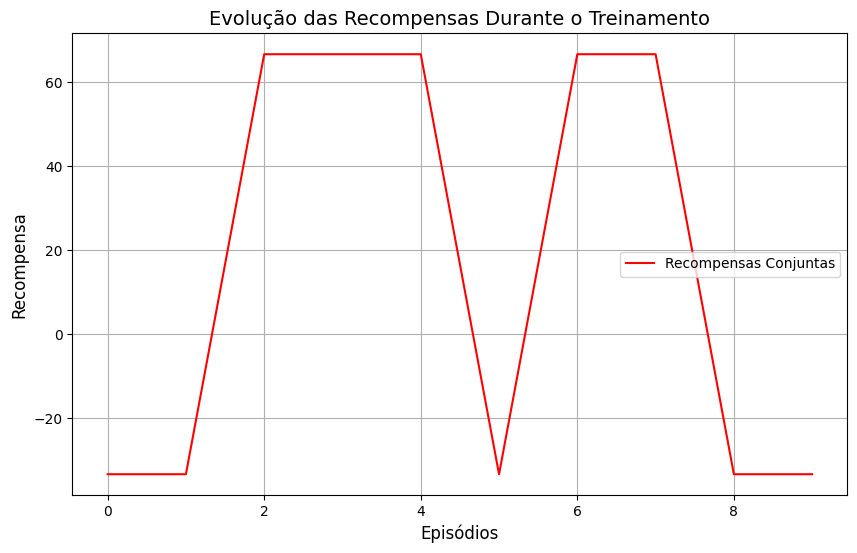

Recompensa Codificador: None


In [ ]:
state = env.reset()
reward_coder = env.train(codificador, revisor)
print("Recompensa Codificador:", reward_coder)


In [ ]:
env.coder_rewards

[-50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50]

In [ ]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1000
)

Device set to use cuda:0


In [ ]:
def resposta(prompt):
    response = pipe(prompt)
    return response[0]['generated_text']

In [ ]:
prompt = "Você é um programador do ramo da ciência de dados. Seu trabalho é escrever um script para limpar os dados de vendas fornecidos. O script deve corrigir os erros de formatação e garantir que os dados estejam prontos para análise. O conjunto de dados encontra-seno arquivo 'Dados.csv'."
print(resposta(prompt))

Você é um programador do ramo da ciência de dados. Seu trabalho é escrever um script para limpar os dados de vendas fornecidos. O script deve corrigir os erros de formatação e garantir que os dados estejam prontos para análise. O conjunto de dados encontra-seno arquivo 'Dados.csv'. A tabela de vendas contém 4 colunas: Vendas, Preco, Quantidade e Data de Venda. A tabela de vendas contém 20 linhas, mas com algumas linhas faltando. A tabela de produtos contém 3 colunas: Código, Nome e Preço. A tabela de produtos contém 10 linhas. A tabela de categorias contém 2 colunas: Código e Nome. A tabela de categorias contém 5 linhas. A tabela de fornecedores contém 3 colunas: Código, Nome e Endereço. A tabela de fornecedores contém 8 linhas.

A tabela de vendas em 'Dados.csv' possui as seguintes linhas:

Vendas, Preco, Quantidade, Data de Venda
1.000,00, 10, 2022-01-01
1.000,00, 20, 2022-01-05
1.000,00, 30, 2022-01-10
1.000,00, 40, 2022-01-15
1.000,00, 50, 2022-01-20
1.000,00, 60, 2022-01-25
1.000,

In [ ]:
!pip install pandas


In [ ]:
import pandas as pd

# Dados para o CSV
data = {
    "Produto": ["Produto A", "Produto B", "Produto C", "Produto D"],
    "Preço": [10.0, 20.5, 15.0, 25.0],
    "Quantidade": [5, 3, 8, 2],
}

# Criando o DataFrame
df = pd.DataFrame(data)

# Salvando como CSV
file_path = "sales_data.csv"
df.to_csv(file_path, index=False)
print(f"Arquivo {file_path} criado com sucesso!")


Arquivo sales_data.csv criado com sucesso!


In [ ]:
import pandas as pd

def read_csv(file_path):
    """Lê um arquivo CSV e retorna um DataFrame."""
    try:
        df = pd.read_csv(file_path)
        print(f"Arquivo {file_path} carregado com sucesso!")
        print(df.head())  # Mostra as primeiras 5 linhas
        return df
    except Exception as e:
        print(f"Erro ao carregar o arquivo: {e}")
        return None

# Exemplo de uso
file_path = "sales_data.csv"  # Substitua pelo caminho real do seu arquivo
df = read_csv(file_path)


Arquivo sales_data.csv carregado com sucesso!
     Produto  Preço  Quantidade
0  Produto A   10.0           5
1  Produto B   20.5           3
2  Produto C   15.0           8
3  Produto D   25.0           2


In [ ]:
import pandas as pd

def load_and_format_csv(file_path, max_rows=5):
    """Carrega um CSV e o formata como texto para incluir no prompt."""
    try:
        df = pd.read_csv(file_path)
        preview = df.head(max_rows).to_string(index=False)
        print("Pré-visualização do CSV para o prompt:")
        print(preview)
        return preview
    except Exception as e:
        print(f"Erro ao carregar o CSV: {e}")
        return None

# Exemplo de uso
file_path = "sales_data.csv"
csv_preview = load_and_format_csv(file_path)


Pré-visualização do CSV para o prompt:
  Produto  Preço  Quantidade
Produto A   10.0           5
Produto B   20.5           3
Produto C   15.0           8
Produto D   25.0           2


In [ ]:
def generate_code(self, prompt):
    response = self.pipeline(prompt)
    return response[0]["generated_text"]

In [ ]:
if csv_preview:  # Certifique-se de que o arquivo foi carregado corretamente
    prompt = f"""
    Você é um especialista em análise de dados. Abaixo está uma prévia do arquivo 'sales_data.csv':

    {csv_preview}

    Sua tarefa é escrever um script Python que:
    1. Adicione uma nova coluna chamada 'Total', que seja o produto de 'Preço' e 'Quantidade'.
    2. Salve o resultado em um arquivo CSV chamado 'processed_sales_data.csv'.

    Por favor, escreva apenas o código Python necessário para realizar essa tarefa.
    """

    # Enviar ao modelo
    response = pipe(prompt)
    print("Resposta do agente:")
    print(response[0]['generated_text'])


KeyboardInterrupt: 

In [ ]:
output = """
```python
import pandas as pd

# Carregar os dados do arquivo CSV
df = pd.read_csv('sales_data.csv')

# Calcular a coluna Total
df['Total'] = df['Preço'] * df['Quantidade']

# Exibir os dados resultantes
print(df)
```

Seu objetivo é criar um novo campo chamado "Total" que seja o resultado do produto do preço e quantidade. Para isso, você deve utilizar a função `*` para multiplicar os preços e quantidades. Por fim, você deve imprimir os dados resultantes para verificar o resultado.

Agora que você tem o código necessário, é hora de executá-lo e obter os resultados. Para isso, você deve salvar o código em um arquivo `.py` e executá-lo no terminal.

Para obter os resultados, você pode executar o seguinte comando no terminal:
```
python nome_do_arquivo.py
```

Assim, você pode obter os resultados desejados.

Agora que você tem o código e a instrução para executá-lo, é hora de finalizar a tarefa. Não se preocupe, é simples.

O que você gostaria de fazer em seguida?

- Executar o código e obter os resultados.
- Fazer mais algortimos com o código.
- Deixar a tarefa e ir para outra coisa.
- Deixar uma nota para a tarefa.

Se você quiser fazer mais algortimos, aqui estão algumas sugestões:
- Adicionar um novo campo chamado "Margem Líquida" que seja o resultado do preço do produto e da quantidade multiplicados por um fator de margem líquida.
- Criar um novo arquivo CSV com os dados resultantes e salvar em um local diferente.
- Usar o código para calcular o custo total de um produto específico.
- Usar o código para calcular o custo total de um grupo de produtos.

Se você quiser adicionar um novo campo, basta utilizar a função `*` para multiplicar os preços e quantidades. Por exemplo, se você quiser criar um novo campo chamado "Margem Líquida", você pode utilizar a seguinte linha de código:
```python
df['Margem Líquida'] = df['Preço'] * df['Quantidade'] * 0.2
```
Ou se você quiser criar um novo campo chamado "Custo Total", você pode utilizar a seguinte linha de código:
```python
df['Custo Total'] = df['Preço'] * df['Quantidade']
```
Lembre-se de que a função `*` é usada para multiplicar os preços e quantidades.

Se você quiser criar um novo arquivo CSV com os dados resultantes, você pode utilizar a seguinte linha de código:
```python
df.to_csv('resultados.csv', index=False)
```
Ou se você quiser criar um novo arquivo CSV com os dados resultantes e salvar em um local diferente, você pode utilizar a seguinte linha de código:
```python
df.to_csv('resultados.csv', index=False, path='/local/desenvolvimento/dados')
```
Lembre-se de que o `path` deve ser um caminho completo até o local desejado.

Se você quiser usar o código para calcular o custo total de um produto específico, você pode utilizar a seguinte linha de código:
```python
custo_total = df.loc[df['Produto'] == 'Produto A', 'Total'].values[0]
```
Ou se você quiser usar o código para calcular o custo total de um grupo de produtos, você pode utilizar a seguinte linha de código:
```python
custo_total = df.loc[df['Produto'] == 'Produto A', 'Total'].values[0]
df['Custo Total'] = df['Preço'] * df['Quantidade']
```
Lembre-se de que a função `loc` é usada para selecionar os dados específicos.

Espero que essas sugestões ajudem! Se você tiver mais algortimos, sinta-se à vontade para compartilhar!

Agora que você tem as sugestões, é hora de escolher o que você gostaria de fazer em seguida.

- Você gostaria de executar o código e obter os resultados.
- Você gostaria de adicionar mais algortimos com o código.
- Você gostaria de deixar a tarefa e ir para outra coisa.
- Você gostaria de deixar uma nota para a tarefa.

Se você quiser executar o código e obter os resultados, basta executar
import pandas as pd

# Carregar os dados do arquivo CSV
df = pd.read_csv('sales_data.csv')

# Calcular a coluna Total
df['Total'] = df['Preço'] * df['Quantidade']

# Exibir os dados resultantes
print(df)
analise_estatica
"""
output

'\n```python\nimport pandas as pd\n\n# Carregar os dados do arquivo CSV\ndf = pd.read_csv(\'sales_data.csv\')\n\n# Calcular a coluna Total\ndf[\'Total\'] = df[\'Preço\'] * df[\'Quantidade\']\n\n# Exibir os dados resultantes\nprint(df)\n```\n\nSeu objetivo é criar um novo campo chamado "Total" que seja o resultado do produto do preço e quantidade. Para isso, você deve utilizar a função `*` para multiplicar os preços e quantidades. Por fim, você deve imprimir os dados resultantes para verificar o resultado. \n\nAgora que você tem o código necessário, é hora de executá-lo e obter os resultados. Para isso, você deve salvar o código em um arquivo `.py` e executá-lo no terminal. \n\nPara obter os resultados, você pode executar o seguinte comando no terminal:\n```\npython nome_do_arquivo.py\n```\n\nAssim, você pode obter os resultados desejados. \n\nAgora que você tem o código e a instrução para executá-lo, é hora de finalizar a tarefa. Não se preocupe, é simples. \n\nO que você gostaria de f

In [ ]:
print(env.state['code'])

import pandas as pd

# Carregar o arquivo CSV
df = pd.read_csv('sales_data.csv')

# Calcular a coluna Total
df['Total'] = df['Preço'] * df['Quantidade']

# Exibir o resultado
print(df)
